# Building & Training A Product Classifier Model
This notebook trains a NLP model using the FastAI/Pytorch library. The model is trained on millions of free-text descriptions of products from over 3500 pharmacies across Australia. The model then predicts the first and second level categories based on the text description.

## Import the required libraries

In [1]:
from fastai.callbacks import *
from fastai.text import *

from sklearn.model_selection import train_test_split

In [2]:
path = './'

## Pre-process Data File

The dataset has been sourced from 3500+ stores stock files as well as the descriptions from master product tree itself. Some departments were excluded as they were either questionable or not in use anymore.

I read in the file below.

In [3]:
text_df = pd.read_csv(path + 'data/product_categorization_20200303.csv', sep=',', low_memory=False)

This dataset as been grouped by the text field before being exported. This means that the dataset only contains unique text labels. A sample of the dataset can be seen below.

In [4]:
text_df.head()

,text,label
0,ACCOLATE TAB 20MG 56,30-PRESCRIPTIONS>3003-RESPIRATORY SYSTEM
1,STILDEM TAB 10MG 20,30-PRESCRIPTIONS>3009-CENTRAL NERVOUS SYSTEM
2,CEFKOR SUSP 125MG/5ML,30-PRESCRIPTIONS>3012-INFECTIONS & INFESTATIONS
3,MAOSIG 300MG X 60 TABS,30-PRESCRIPTIONS>3009-CENTRAL NERVOUS SYSTEM
4,CLINISTIX STRIPS 50,30-PRESCRIPTIONS>3017-DIAGNOSTIC AGENTS


Double check there are no duplicates. Duplicates if present across the train and validation sets would mean data leakage and not give a clear idea of the model's ability to genralise.

In [5]:
text_df.drop_duplicates(subset=['text'], inplace=True)

Check the length of the dataset.

In [7]:
len(text_df)

6324730

Over 6m uniquely spelled variants of product names. For reference, there is only 560k unique products in the master product trree itself. That means on average there is ~11 variants of spelling for each product.

Given we have so many exmaples. Setting the test/validation set to 15/20% as per industry norm seemed a bit excessive, I will set it to something smaller.

This is based on guidance provided by Andrew Ng's Deep learning course. We are going to use a smaller percentage (2.5%) as this still gives use many thousands of unique, unseen examples to validate our models performance.

In [9]:
len(text_df)*0.025

158118.25

Split the dataset into train/validation/test

In [10]:
train, test = train_test_split(text_df, test_size=0.025, random_state=42, shuffle=True)
train, valid = train_test_split(train, test_size=0.025, random_state=42, shuffle=True)

Check the lengths of each set

In [12]:
len(train)

6012445

In [13]:
len(test)

158119

In [14]:
len(valid)

154166

Drop any null values

In [15]:
train.dropna(inplace=True)
valid.dropna(inplace=True)
test.dropna(inplace=True)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Write cleaned/formatted file out to disk for loading in later if needed.

In [16]:
train.to_csv(path+'data/train.csv', sep=',', header=True, index=False)
valid.to_csv(path+'data/valid.csv', sep=',', header=True, index=False)
test.to_csv(path+'data/test.csv', sep=',', header=True, index=False)

## Create DataBunch Objects
Here we will use the train/validation/test dataframes to create databunch objects.

In [18]:
# Language model data
data_lm = TextLMDataBunch.from_df(path,
                                  train_df=train,
                                  valid_df=valid,
                                  test_df=test,
                                  label_cols='label',
                                  text_cols='text')

In [20]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path,
                                      train_df=train,
                                      valid_df=valid,
                                      test_df=test,
                                      label_cols='label',
                                      text_cols='text',
                                      vocab=data_lm.train_ds.vocab, bs=128)

The above step takes some time to complete. We can write the objects out to a file for re-importing later. This helps when you want to create a new model from the same data.

In [21]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

The databunch objects can be read back in using the below. The batch size can be changed when loading back in also.

In [ ]:
data_lm = load_data(path, 'data_lm_export.pkl')
data_clas = load_data(path, 'data_clas_export.pkl', bs=128)

## Traing the language encoder
We will use a pre-trained language model and fine-tune it to understand the Catman vocabulary. The below call will download the pre-trained model from FastAI if it hasnt been used before.

***Note:*** *I used multi precision model training for speed. This is enabled by the .to_fp16() call at the end. This is only available for newer versions of Nvidia GPU's. This has been trained on a V100 GPU.*

In [22]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5).to_fp16()

Find the best learning rate

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-02
Min loss divided by 10: 9.12E-02


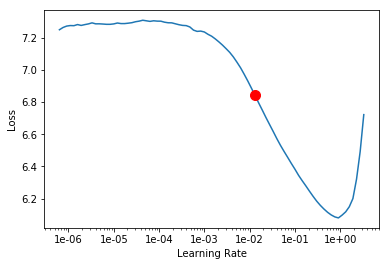

In [24]:
learn.recorder.plot(suggestion=True)

In [26]:
min_grad_lr = 1.32E-02

Train the last layers of the language model for a little bit.

In [ ]:
callbacks=[SaveModelCallback(learn, every='improvement', name='best_lm_1'),
           CSVLogger(learn=learn, filename='best_lm_1_history')]

learn.fit_one_cycle(3, min_grad_lr, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,3.220717,2.979194,0.523773,16:10
1,3.067882,2.835282,0.535246,16:11
2,2.972154,2.732000,0.545610,16:11


Better model found at epoch 0 with valid_loss value: 2.979193925857544.
Better model found at epoch 1 with valid_loss value: 2.835282325744629.
Better model found at epoch 2 with valid_loss value: 2.7320001125335693.


Unfreeze the earlier pre-trained layers and train a little bit more. Note the use of a smaller learning rate as we dont want to destroy the weights in the pretrained model.

In [32]:
callbacks=[SaveModelCallback(learn, every='improvement', name='best_lm_2'),
           CSVLogger(learn=learn, filename='best_lm_2_history')]
learn.unfreeze()
learn.fit_one_cycle(3, slice(min_grad_lr/40., min_grad_lr/2.), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,2.566533,2.477286,0.573012,18:19
1,2.399263,2.291761,0.592465,18:24
2,2.293876,2.205079,0.603713,18:23


Better model found at epoch 0 with valid_loss value: 2.477285861968994.
Better model found at epoch 1 with valid_loss value: 2.2917611598968506.
Better model found at epoch 2 with valid_loss value: 2.205078601837158.


Test the language models ability to predict the next words.

In [33]:
learn.predict("Banana Boat", n_words=6)

'Banana Boat Sunscn Clr Spray'

Save the encoder for use in the language classifier

In [34]:
learn.save_encoder('ft_enc')

## Train the Text Classifier
create the learner. again its using a pretrained model architecture. Here we also load in the encoder previously trained.

In [5]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6012444 items)
x: TextList
xxbos xxup trinket xxup box xxup grey xxup cement xxup with xxup gold xxup lid,xxbos xxup barnes xxup apple xxup cider xxup xxunk,xxbos xxup lynx xxup deod xxup marine 100 g,xxbos xxup eng xxup tea xxup shop xxup pack xxup your xxup wellnes,xxbos xxup hped xxup indiana xxup rosso 6
y: CategoryList
45-GIFTWARE>4501-GIFTWARE,4-FUNCTIONAL FOODS>403-HEALTH FOODS,17-MENS>1707-DEODORANTS,4-FUNCTIONAL FOODS>406-TEA,14-FOOTWEAR>1401-FOOTWEAR
Path: .;

Valid: LabelList (154166 items)
x: TextList
xxbos xxup ch xxup le xxup vernis 713 xxup pure xxup blk 1 xxup sh,xxbos xxup ws xxup adelaide xxup earrings xxup slvr,xxbos n / w xxup vita - xxup gummies xxup vit xxup d3 60s,xxbos xxup s26 xxup gold xxup delicateeze,xxbos xxup homy xxup ped xxup echo xxup cranberry 9.5
y: CategoryList
3-COSMETICS/COLOUR>301-PRESTIGE COSMETICS,45-GIFTWARE>4501-GIFTWARE,7-NATURAL MEDICINE>703-MUSCULAR SUPPORT,2-BABY>201-INFANT FORMULA,14-F

Again find the best learning rate

In [6]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-02
Min loss divided by 10: 5.25E-02


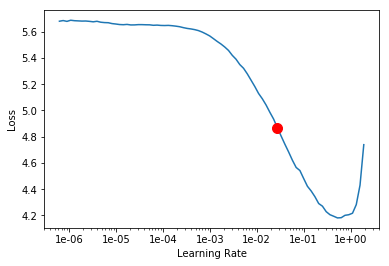

In [7]:
learn.recorder.plot(suggestion=True)

In [8]:
min_grad_lr = 2.75E-02

Train the last few layers to classify

In [9]:
callbacks=[SaveModelCallback(learn, every='improvement', name='best_cm'),
           CSVLogger(learn=learn, filename='best_cm_1_history')]

learn.fit_one_cycle(5, min_grad_lr, wd=0.25, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,1.469449,1.316688,0.684418,12:34
1,1.550105,1.497035,0.650461,12:29
2,1.438705,1.216079,0.701251,12:36
3,1.240721,1.020598,0.743932,12:31
4,1.067234,0.858037,0.780652,12:28


Better model found at epoch 0 with valid_loss value: 1.3166879415512085.
Better model found at epoch 2 with valid_loss value: 1.2160794734954834.
Better model found at epoch 3 with valid_loss value: 1.0205976963043213.
Better model found at epoch 4 with valid_loss value: 0.8580366373062134.


Unfreeze some more layers and train a bit more.

In [10]:
callbacks=[SaveModelCallback(learn, every='improvement', name='best_cm_2'),
           CSVLogger(learn=learn, filename='best_cm_2_history')]

learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(min_grad_lr/4., min_grad_lr/2.), wd=0.25, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,1.180214,1.014397,0.750723,14:55
1,1.246676,1.109925,0.735376,15:02
2,1.101609,0.955001,0.767374,15:00
3,0.963187,0.785881,0.801753,14:59
4,0.744348,0.604484,0.844596,15:02


Better model found at epoch 0 with valid_loss value: 1.014397144317627.
Better model found at epoch 2 with valid_loss value: 0.9550012350082397.
Better model found at epoch 3 with valid_loss value: 0.785880982875824.
Better model found at epoch 4 with valid_loss value: 0.6044842600822449.


Unfreeze all layers and train a bit more. 

Again, note the use of a smaller learning rate as we dont want to destroy the weights in the pretrained model.

In [ ]:
callbacks=[SaveModelCallback(learn, every='improvement', name='best_cm_3'),
           CSVLogger(learn=learn, filename='best_cm_3_history')]

learn.unfreeze()
learn.fit_one_cycle(6, slice(min_grad_lr/20., min_grad_lr/2.), wd=0.25, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,0.937934,0.824009,0.809459,21:26
1,1.022691,0.953447,0.784550,21:27
2,0.992598,0.887412,0.796246,21:27
3,0.836387,0.748358,0.826246,21:35
4,0.676942,0.597119,0.857679,21:13
5,0.535882,0.459578,0.887193,21:30


Better model found at epoch 0 with valid_loss value: 0.8240089416503906.
Better model found at epoch 3 with valid_loss value: 0.7483584880828857.
Better model found at epoch 4 with valid_loss value: 0.597118616104126.
Better model found at epoch 5 with valid_loss value: 0.4595775604248047.


Ended up with 88.71% accuracy in the validation set. This is pretty good for text that it has never seen before.

In [15]:
learn.to_fp32()

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6012444 items)
x: TextList
xxbos xxup trinket xxup box xxup grey xxup cement xxup with xxup gold xxup lid,xxbos xxup barnes xxup apple xxup cider xxup xxunk,xxbos xxup lynx xxup deod xxup marine 100 g,xxbos xxup eng xxup tea xxup shop xxup pack xxup your xxup wellnes,xxbos xxup hped xxup indiana xxup rosso 6
y: CategoryList
45-GIFTWARE>4501-GIFTWARE,4-FUNCTIONAL FOODS>403-HEALTH FOODS,17-MENS>1707-DEODORANTS,4-FUNCTIONAL FOODS>406-TEA,14-FOOTWEAR>1401-FOOTWEAR
Path: .;

Valid: LabelList (154166 items)
x: TextList
xxbos xxup ch xxup le xxup vernis 713 xxup pure xxup blk 1 xxup sh,xxbos xxup ws xxup adelaide xxup earrings xxup slvr,xxbos n / w xxup vita - xxup gummies xxup vit xxup d3 60s,xxbos xxup s26 xxup gold xxup delicateeze,xxbos xxup homy xxup ped xxup echo xxup cranberry 9.5
y: CategoryList
3-COSMETICS/COLOUR>301-PRESTIGE COSMETICS,45-GIFTWARE>4501-GIFTWARE,7-NATURAL MEDICINE>703-MUSCULAR SUPPORT,2-BABY>201-INFANT FORMULA,14-F

## Test model

Small helper function that wraps the learn.predict() to allow getting the top n predictions.

In [12]:
def get_n_pred(learn, text, n=None):
    classes = learn.data.classes
    pred_cat, _, probs = learn.predict(text)
    confidences = {c: p for c, p in zip(classes, probs.tolist())}
    if n:
        return {k: v for k, v in sorted(confidences.items(), key=lambda item: item[1], reverse=True)[:n]}       

Give it some text and see where it classifies it.

In [17]:
text = 'Hello Kitty Bubblegum Body Mist Spray 75g'

get_n_pred(learn, text, 5)

{'6-DEODORANTS>601-WOMEN': 0.9244009852409363,
 '45-GIFTWARE>4501-GIFTWARE': 0.027526648715138435,
 '31-FRAGRANCES>3102-WOMEN': 0.012997721321880817,
 '17-MENS>1707-DEODORANTS': 0.007795216049998999,
 '6-DEODORANTS>603-THERAPEUTIC': 0.006786595564335585}

## Export model file for use in app

In [16]:
learn.export(path+'export.pkl')

You can load the learner model into a new application by calling the load_learner() function from the FastAI Library. You can then just call the normal learn.predict() to get a single prediction.

To go bulk/batch predictions, iterating over the single prediction method will be too slow. YOu will need to add the bulk prediction as a test set then call learn.get_preds(). Refer to FastAI docs on how to do this.

In [ ]:
learn = load_learner(path=path, file='export.pkl')
learn.predict(text)

## Reload previously trained model and data

In [ ]:
path = './'

data_clas = load_data(path, 'data_clas_export.pkl', bs=128)

learn = text_classifier_learner(data=data_clas ,arch=AWD_LSTM, drop_mult=0.5)
learn.load('best_cm_3')